In [1]:
import numpy as np
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import psycopg2
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
import tensorflow as tf
import tensorflow.keras.backend as K
from faiss import read_index
from psycopg2.extras import execute_values
import pickle
import pandas as pd
from operator import itemgetter

2023-11-08 12:23:48.293718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load fair rank

In [2]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="54320",
    database="stack_overflow",
)

In [3]:
after_fair_df = pd.read_csv("after_fair_data.csv")
after_fair_df.head()

,q_id,u_id,developed_country,idx,pscore
0,70547027,100297,1,0,2.340971
1,70547027,7574575,0,1,2.266549
2,70547027,11923558,0,2,2.071728
3,70547027,1624921,1,3,2.033441
4,70547027,325565,1,4,1.930067


In [4]:
with connection:
    with connection.cursor() as cursor:
        execute_values(
            cursor,
            """select q_id, u_id, q_a.score
            FROM (VALUES %s) AS base_questions (q_id, u_id)
            JOIN posts_19 q_a ON q_a.parent_id = q_id
            WHERE q_a.owner_user_id=u_id""",
            after_fair_df[["q_id", "u_id"]].values.tolist(),
            page_size=len(after_fair_df),
        )
        answers_dataset = pd.DataFrame(
            cursor.fetchall(), columns=["q_id", "u_id", "score"]
        )

In [5]:
full_dataset = after_fair_df.merge(answers_dataset, on=["q_id", "u_id"], how="left")
full_dataset["is_answer"] = (~full_dataset["score"].isna()).astype(int)
full_dataset = full_dataset.sort_values(by=["q_id", "pscore"], ascending=False)
full_dataset.head()

,q_id,u_id,developed_country,idx,pscore,score,is_answer
397200,74681417,100297,1,0,2.263848,NaN,0
397201,74681417,3874623,1,1,2.024328,NaN,0
397202,74681417,5923139,1,2,1.902712,NaN,0
397203,74681417,7574575,0,3,1.897878,NaN,0
397204,74681417,325565,1,4,1.845899,NaN,0


In [6]:
full_dataset["is_answer"].sum()

444

# Evaluate recall

In [7]:
posts_ids = full_dataset["q_id"].unique().tolist()
len(posts_ids)

3973

In [14]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """SELECT q_a.parent_id, u.high_hdi, count(*) as answers
                FROM posts_19 q_a
                JOIN users u ON q_a.owner_user_id=u.id
                where q_a.parent_id in %s
                AND u.high_hdi IS NOT NULL
                group by q_a.parent_id, u.high_hdi""",
            (tuple(posts_ids),),
        )
        q_answers_result = cursor.fetchall()

In [16]:
q_answers = dict()
q_answers_dev_country = dict()
q_answers_no_dev_country = dict()

for q_id, high_hdi, answers in q_answers_result:
    if high_hdi:
        q_answers_dev_country[q_id] = answers
    else:
        q_answers_no_dev_country[q_id] = answers
    q_answers[q_id] = q_answers.get(q_id, 0) + answers

len(q_answers), len(q_answers_dev_country), len(q_answers_no_dev_country)

(3770, 2788, 2806)

In [80]:
top_k = range(0, 100, 2)

dev_dataset = full_dataset[full_dataset["developed_country"] == 1]
no_dev_dataset = full_dataset[full_dataset["developed_country"] == 0]

mean_recall = []
dev_mean_recall = []
no_dev_mean_recall = []
std_recall = []
dev_std_recall = []
no_dev_std_recall = []
median_recall = []
iqr_recall = []
for k in top_k:
    all_recall = (full_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
                / q_answers[x["q_id"].iloc[0]]
                if x["q_id"].iloc[0] in q_answers
                else np.NaN
            )
        )
        .dropna())
    mean_recall.append(all_recall.mean())
    std_recall.append(all_recall.std())
    median_recall.append(all_recall.median())
    q75, q25 = np.percentile(all_recall, [75 ,25])
    iqr_recall.append(q75 - q25)
    
    dev_recall = (dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
                / q_answers_dev_country[x["q_id"].iloc[0]]
                if x["q_id"].iloc[0] in q_answers_dev_country
                else np.NaN
            )
        )
        .dropna())
    dev_mean_recall.append(dev_recall.mean())
    dev_std_recall.append(dev_recall.std())
    
    no_dev_recall = (no_dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
                / q_answers_no_dev_country[x["q_id"].iloc[0]]
                if x["q_id"].iloc[0] in q_answers_no_dev_country
                else np.NaN
            )
        )
        .dropna()
    )
    no_dev_mean_recall.append(no_dev_recall.mean())
    no_dev_std_recall.append(no_dev_recall.std())

In [65]:
sum(all_recall == 0)/len(all_recall), median_recall[-3:], iqr_recall[-3:]

(0.9116710875331565, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

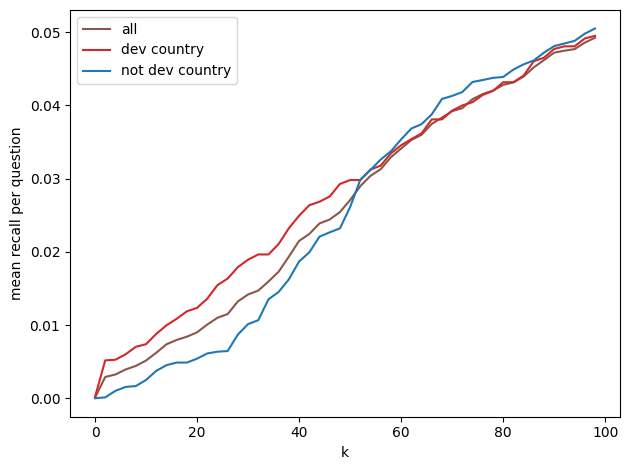

In [88]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall per question")
ax1.plot(top_k, mean_recall, color="tab:brown", label="all")
ax1.plot(top_k, dev_mean_recall, color=color, label="dev country")
ax1.plot(top_k, no_dev_mean_recall, color="tab:blue", label="not dev country")

fig.tight_layout()
ax1.legend()

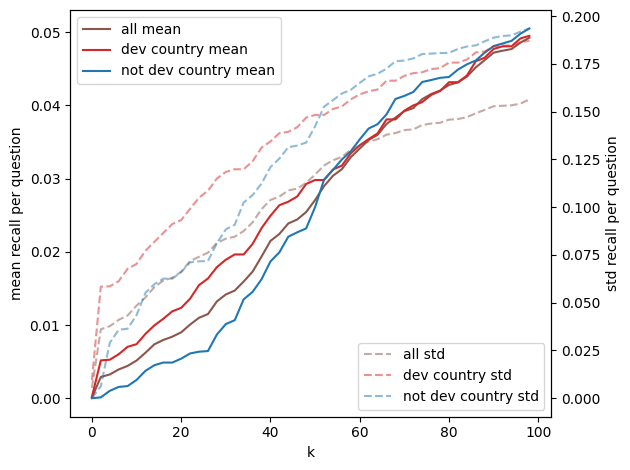

In [87]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall per question")
ax1.plot(top_k, mean_recall, color="tab:brown", label="all mean")
ax1.plot(top_k, dev_mean_recall, color=color, label="dev country mean")
ax1.plot(top_k, no_dev_mean_recall, color="tab:blue", label="not dev country mean")

ax2 = ax1.twinx()
ax2.set_ylabel("std recall per question")
ax2.plot(top_k, std_recall, linestyle="--", alpha=0.5, color="tab:brown", label="all std")
ax2.plot(top_k, dev_std_recall, linestyle="--", alpha=0.5, color=color, label="dev country std")
ax2.plot(top_k, no_dev_std_recall, linestyle="--", alpha=0.5, color="tab:blue", label="not dev country std")

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
fig.tight_layout()

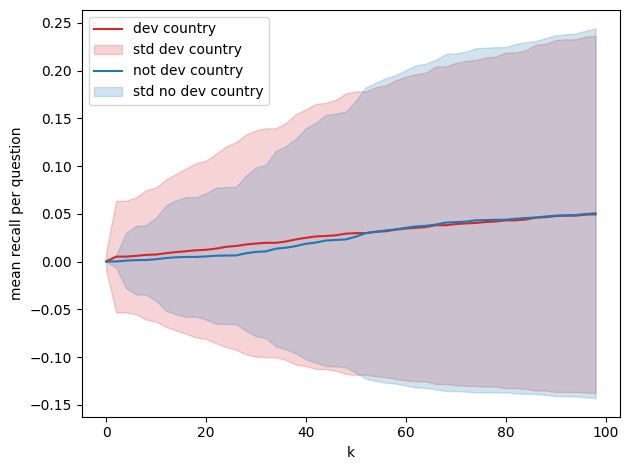

In [90]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall per question")
ax1.plot(top_k, dev_mean_recall, color=color, label="dev country")
plt.fill_between(top_k, [m - r for m, r in zip(dev_mean_recall, dev_std_recall)],
                 [m + r for m, r in zip(dev_mean_recall, dev_std_recall)],
                 alpha=0.2, color="tab:red", label='std dev country')
ax1.plot(top_k, no_dev_mean_recall, color="tab:blue", label="not dev country")
ax1.fill_between(top_k, [m - r for m, r in zip(no_dev_mean_recall, no_dev_std_recall)],
                 [m + r for m, r in zip(no_dev_mean_recall, no_dev_std_recall)],
                 alpha=0.2, color="tab:blue", label='std no dev country')

fig.tight_layout()
ax1.legend(loc='upper left')

In [91]:
[(m, r) for m, r in zip(mean_recall[:5], std_recall[:5])]

[(8.841732979664014e-05, 0.005428852849870469),
 (0.0029045092838196284, 0.036071437024748285),
 (0.003244916003536693, 0.03771022547209723),
 (0.0039301503094606545, 0.04104032263759454),
 (0.0044164456233421745, 0.04330767642029844)]

In [92]:
(full_dataset[["is_answer", "q_id", "idx"]]
.groupby("q_id")
.apply(
    lambda x: (
        x[x["idx"] <= 70]["is_answer"].sum()
        / q_answers[x["q_id"].iloc[0]]
        if x["q_id"].iloc[0] in q_answers
        else np.NaN
    )
)
.dropna()
.mean())

0.0392130857648099

In [93]:
(dev_dataset[["is_answer", "q_id", "idx"]]
.groupby("q_id")
.apply(
    lambda x: (
        x[x["idx"] <= 70]["is_answer"].sum()
        / q_answers_dev_country[x["q_id"].iloc[0]]
        if x["q_id"].iloc[0] in q_answers_dev_country
        else np.NaN
    )
)
.dropna()
.mean()
)

0.039275466284074606

In [94]:
(no_dev_dataset[["is_answer", "q_id", "idx"]]
.groupby("q_id")
.apply(
    lambda x: (
        x[x["idx"] <= 70]["is_answer"].sum()
        / q_answers_no_dev_country[x["q_id"].iloc[0]]
        if x["q_id"].iloc[0] in q_answers_no_dev_country
        else np.NaN
    )
)
.dropna()
.mean()
)

0.04129246851983844

In [95]:
(full_dataset[["is_answer", "q_id", "idx"]]
.groupby("q_id")
.apply(
    lambda x: (
        x[x["idx"] <= 70]["is_answer"].sum()
    )
)
.sum())

353

In [96]:
sum(q_answers.values())

8957

In [97]:
(dev_dataset[["is_answer", "q_id", "idx"]]
.groupby("q_id")
.apply(
    lambda x: (
        x[x["idx"] <= 70]["is_answer"].sum()
    )
)
.sum()
)

177

In [98]:
sum(q_answers_dev_country.values())

4359

In [99]:
(no_dev_dataset[["is_answer", "q_id", "idx"]]
.groupby("q_id")
.apply(
    lambda x: (
        x[x["idx"] <= 70]["is_answer"].sum()
    )
)
.sum()
)

176

In [100]:
sum(q_answers_no_dev_country.values())

4598